In [1]:
from lib.rebalance.account_drift_rebalance import * 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys, os
cwd = os.getcwd()
from pathlib import Path
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import datetime
import decimal
from pandas_datareader import data as pdr

now = datetime.datetime.now()

In [4]:
# drift params updated line ~13

In [5]:
# portfolio targets "t"
columns_t = ['ticker','allocation_target','assetclass']
positions_t = [
    ['SPY',0.1,'ETF'],
    ['IWM',0.1,'ETF'],
    ['QQQ',0.1,'ETF'],
    ['XLF',0.1,'ETF'],
    ['XLI',0.1,'ETF'],
    ['EEM',0.1,'ETF'],
    ['XLV',0.1,'ETF'],
    ['IAU',0.1,'ETF'],
    ['TLT',0.1,'ETF'],
    ['SHV',0.05,'ETF'],
    ['HYG',0.05,'ETF'],
    ]

# portfolio current holdings "c"
columns_c = ['accounttype','accountid','lastrebaldate','ticker','assetclass','basisdate','costbasis','shares']
positions_c = [     ['IRA','0001','2020-11-16','SPY','ETF','2018-11-16', 260   ,913.483],    # traditional ira   
                    ['IRA','0001','2020-11-16','QQQ','ETF','2018-11-16', 175  ,514.298],
                    ['IRA','0001','2020-11-16','XLF','ETF','2018-11-16',  27  ,151.121],

                    ['401K','0002','2020-11-16','SPY','ETF','2018-11-16',  260  ,772.407],    # 401k
                    ['401K','0002','2020-11-16','IWM','ETF','2018-11-16',  157  ,151.578],

                    ['IRA','0003','2020-11-16','HYG','ETF','2018-11-16', 85   ,3.14],         # roth
                    ['IRA','0003','2020-11-16','IAU','ETF','2018-11-16',  18   ,549.871]        
              ]

In [6]:
tickers, targetalloc, start_port, agg_port = build_initial_portfolios(columns_t, positions_t, columns_c, positions_c)

In [7]:
targetalloc.head()

,ticker,allocation_target,assetclass
0,SPY,0.1,ETF
1,IWM,0.1,ETF
2,QQQ,0.1,ETF
3,XLF,0.1,ETF
4,XLI,0.1,ETF


In [8]:
start_port.head()

,accounttype,accountid,lastrebaldate,ticker,assetclass,basisdate,costbasis,shares
0,IRA,0001,2020-11-16,SPY,ETF,2018-11-16,260,913.483
1,IRA,0001,2020-11-16,QQQ,ETF,2018-11-16,175,514.298
2,IRA,0001,2020-11-16,XLF,ETF,2018-11-16,27,151.121
3,401K,0002,2020-11-16,SPY,ETF,2018-11-16,260,772.407
4,401K,0002,2020-11-16,IWM,ETF,2018-11-16,157,151.578


In [9]:
agg_port.head()

,lastrebaldate,assetclass,basisdate,costbasis,shares
ticker,,,,,
HYG,2020-11-16,ETF,2018-11-16,85.0,3.140
IAU,2020-11-16,ETF,2018-11-16,18.0,549.871
IWM,2020-11-16,ETF,2018-11-16,157.0,151.578
QQQ,2020-11-16,ETF,2018-11-16,175.0,514.298
SPY,2020-11-16,ETF,2018-11-16,260.0,1685.890


In [10]:
ohlc = retrieve_latest_security_price(tickers)
ohlc = ohlc.to_frame(name='close').reset_index(level=1, drop=True)

...retrieving current market price data...
Tickers Not Found:  []


In [11]:
final_port = build_initial_drift_df(agg_port, targetalloc, ohlc)
final_port.head()

,ticker,lastrebaldate,assetclass,basisdate,costbasis,shares,allocation_target,close,value,allocation,correction,new_money_in
0,HYG,2020-11-16,ETF,2018-11-16,85.0,3.140,0.05,76.95,241.62300,0.000260,0.049740,50.0
1,IAU,2020-11-16,ETF,2018-11-16,18.0,549.871,0.10,33.15,18228.22365,0.019579,0.080421,100.0
2,IWM,2020-11-16,ETF,2018-11-16,157.0,151.578,0.10,194.65,29504.65770,0.031692,0.068308,100.0
3,QQQ,2020-11-16,ETF,2018-11-16,175.0,514.298,0.10,322.86,166046.25228,0.178355,-0.078355,100.0
4,SPY,2020-11-16,ETF,2018-11-16,260.0,1685.890,0.10,422.14,711681.60460,0.764439,-0.664439,100.0


In [12]:
rebal_port, stable_port = build_initial_order_df(final_port)

In [13]:
rebal_port.head()

,ticker,lastrebaldate,assetclass,basisdate,costbasis,shares,allocation_target,close,value,allocation,...,rebal_flag_time,rebal_flag_exit,rebal_flag_newmoney,rebal_flag,value_chg,shares_chg,final_shares_chg,new_shares,new_value,new_value_chg
0,HYG,2020-11-16,ETF,2018-11-16,85.0,3.140,0.05,76.95,241.62300,0.000260,...,0,0,1,1,46357.654569,602.438656,602.0,605.140,46565.52300,46323.90
1,IAU,2020-11-16,ETF,2018-11-16,18.0,549.871,0.10,33.15,18228.22365,0.019579,...,0,0,1,1,74970.331489,2261.548461,2261.0,2810.871,93180.37365,74952.15
2,IWM,2020-11-16,ETF,2018-11-16,157.0,151.578,0.10,194.65,29504.65770,0.031692,...,0,0,1,1,63693.897439,327.222694,327.0,478.578,93155.20770,63650.55
3,QQQ,2020-11-16,ETF,2018-11-16,175.0,514.298,0.10,322.86,166046.25228,0.178355,...,0,0,1,1,-72847.697141,-225.632463,-225.0,289.298,93402.75228,-72643.50
4,SPY,2020-11-16,ETF,2018-11-16,260.0,1685.890,0.10,422.14,711681.60460,0.764439,...,0,0,1,1,-618483.049461,-1465.113587,-1465.0,220.890,93246.50460,-618435.10


In [14]:
stable_port.head()

,ticker,lastrebaldate,assetclass,basisdate,costbasis,shares,allocation_target,close,value,allocation,correction,new_money_in,timedelta,rebal_flag_thresh,rebal_flag_time,rebal_flag_exit,rebal_flag_newmoney,rebal_flag


In [15]:
exec_port = build_execution_df(stable_port, rebal_port)
exec_port.head()

,ticker,lastrebaldate,assetclass,basisdate,costbasis,shares,allocation_target,close,value,allocation,correction,new_money_in,rebal_flag,final_shares_chg,new_shares,new_value,new_value_chg,final_allocation
0,HYG,2020-11-16,ETF,2018-11-16,85.0,3.140,0.05,76.95,241.62300,0.000260,0.049740,50.0,1,602.0,605.140,46565.52300,46323.90,0.049969
1,IAU,2020-11-16,ETF,2018-11-16,18.0,549.871,0.10,33.15,18228.22365,0.019579,0.080421,100.0,1,2261.0,2810.871,93180.37365,74952.15,0.099991
2,IWM,2020-11-16,ETF,2018-11-16,157.0,151.578,0.10,194.65,29504.65770,0.031692,0.068308,100.0,1,327.0,478.578,93155.20770,63650.55,0.099964
3,QQQ,2020-11-16,ETF,2018-11-16,175.0,514.298,0.10,322.86,166046.25228,0.178355,-0.078355,100.0,1,-225.0,289.298,93402.75228,-72643.50,0.100230
4,SPY,2020-11-16,ETF,2018-11-16,260.0,1685.890,0.10,422.14,711681.60460,0.764439,-0.664439,100.0,1,-1465.0,220.890,93246.50460,-618435.10,0.100062


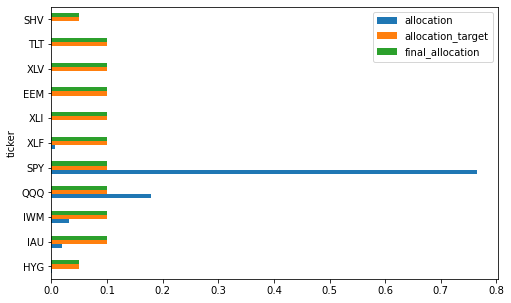

In [16]:
graph_port = exec_port[['ticker','allocation','allocation_target','final_allocation']].copy()
graph_port.plot.barh(x='ticker',figsize=(8,5))
plt.show()

In [17]:
port = merge_drift_and_execution(start_port, exec_port)
port.head()

,accounttype,accountid,ticker,shares,assetclass,close,value,final_shares_chg,new_shares,new_value,new_value_chg,final_allocation,value_orig,tick_alloc
0,IRA,0003,HYG,3.140,ETF,76.95,241.62300,602.0,605.140,46565.52300,46323.90,0.049969,241.62300,1.00000
1,IRA,0003,IAU,549.871,ETF,33.15,18228.22365,2261.0,2810.871,93180.37365,74952.15,0.099991,18228.22365,1.00000
2,401K,0002,IWM,151.578,ETF,194.65,29504.65770,327.0,478.578,93155.20770,63650.55,0.099964,29504.65770,1.00000
3,IRA,0001,QQQ,514.298,ETF,322.86,166046.25228,-225.0,289.298,93402.75228,-72643.50,0.100230,166046.25228,1.00000
4,IRA,0001,SPY,913.483,ETF,422.14,711681.60460,-1465.0,220.890,93246.50460,-618435.10,0.100062,385617.71362,0.54184


In [18]:
port = catch_edge_cases(port)
port.head()

,accounttype,accountid,ticker,shares,assetclass,close,value,final_shares_chg,new_shares,new_value,new_value_chg,final_allocation
0,IRA,0003,HYG,3.140,ETF,76.95,241.62300,602.000000,605.140000,46565.523000,46323.900000,0.049969
1,IRA,0003,IAU,549.871,ETF,33.15,18228.22365,2261.000000,2810.871000,93180.373650,74952.150000,0.099991
2,401K,0002,IWM,151.578,ETF,194.65,29504.65770,327.000000,478.578000,93155.207700,63650.550000,0.099964
3,IRA,0001,QQQ,514.298,ETF,322.86,166046.25228,-225.000000,289.298000,93402.752280,-72643.500000,0.100230
4,IRA,0001,SPY,913.483,ETF,422.14,385617.71362,-793.795915,119.687085,50524.706097,-335093.007523,0.054218
